# Flopy MODFLOW 6 (MF6) Support

The Flopy library contains classes for creating, saving, running, loading, and modifying MF6 simulations.  The MF6 portion of the flopy library is located in:

*flopy.mf6*

While there are a number of classes in flopy.mf6, to get started you only need to use the main classes summarized below:

flopy.mf6.MFSimulation  
* MODFLOW Simulation Class.  Entry point into any MODFLOW simulation.

flopy.mf6.ModflowGwf
* MODFLOW Groundwater Flow Model Class.  Represents a single model in a simulation.

flopy.mf6.Modflow[pc]
    * MODFLOW package classes where [pc] is the abbreviation of the package name.  Each package is a separate class.  

For packages that are part of a groundwater flow model, the abbreviation begins with "Gwf".  For example, "flopy.mf6.ModflowGwfdis" is the Discretization package.
  

In [1]:
import os
import sys
from shutil import copyfile

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
    
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

flopy is installed in /Users/jdhughes/Documents/Development/flopy_git/flopy_fork/flopy
3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 14:38:56) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.17.3
matplotlib version: 3.1.1
flopy version: 3.3.0


# Creating a MF6 Simulation

A MF6 simulation is created by first creating a simulation object "MFSimulation".  When you create the simulation object you can define the simulation's name, version, executable name, workspace path, and the name of the tdis file.  All of these are optional parameters, and if not defined each one will default to the following:

sim_name='modflowtest'

version='mf6'

exe_name='mf6.exe'

sim_ws='.'

sim_tdis_file='modflow6.tdis'

In [2]:
import os
import sys
from shutil import copyfile
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

sim_name = 'example_sim'
sim_path = os.path.join('data', 'example_project')
sim = flopy.mf6.MFSimulation(sim_name=sim_name, version='mf6', exe_name='mf6', 
                             sim_ws=sim_path)

The next step is to create a tdis package object "ModflowTdis".  The first parameter of the ModflowTdis class is a simulation object, which ties a ModflowTdis object to a specific simulation.  The other parameters and their definitions can be found in the docstrings.

In [3]:
tdis = flopy.mf6.ModflowTdis(sim, pname='tdis', time_units='DAYS', nper=2, 
                             perioddata=[(1.0, 1, 1.0), (10.0, 5, 1.0)])

Next one or more models are created using the ModflowGwf class.  The first parameter of the ModflowGwf class is the simulation object that the model will be a part of.

In [4]:
model_name = 'example_model'
model = flopy.mf6.ModflowGwf(sim, modelname=model_name,
                             model_nam_file='{}.nam'.format(model_name))

Next create one or more Iterative Model Solution (IMS) files.

In [5]:
ims_package = flopy.mf6.ModflowIms(sim, pname='ims', print_option='ALL',
                                   complexity='SIMPLE', outer_hclose=0.00001,
                                   outer_maximum=50, under_relaxation='NONE',
                                   inner_maximum=30, inner_hclose=0.00001,
                                   linear_acceleration='CG',
                                   preconditioner_levels=7,
                                   preconditioner_drop_tolerance=0.01,
                                   number_orthogonalizations=2)

Each ModflowGwf object needs to be associated with an ModflowIms object.  This is done by calling the MFSimulation object's "register_ims_package" method.  The first parameter in this method is the ModflowIms object and the second parameter is a list of model names (strings) for the models to be associated with the ModflowIms object.

In [6]:
sim.register_ims_package(ims_package, [model_name])

Next add packages to each model.  The first package added needs to be a spatial discretization package since flopy uses  information from the spatial discretization package to help you build other packages.  There are three spatial discretization packages to choose from:

DIS (ModflowGwfDis) - Structured discretization
DISV (ModflowGwfdisv) - Discretization with vertices
DISU (ModflowGwfdisu) - Unstructured discretization

In [7]:
dis_package = flopy.mf6.ModflowGwfdis(model, pname='dis', length_units='FEET', nlay=2,
                                      nrow=2, ncol=5, delr=500.0,
                                      delc=500.0,
                                      top=100.0, botm=[50.0, 20.0],
                                      filename='{}.dis'.format(model_name))

## Accessing Namefiles

Namefiles are automatically built for you by flopy.  However, there are some options contained in the namefiles that you may want to set. To get the namefile object access the name_file attribute in either a simulation or model object to get the simulation or model namefile.

In [8]:
# set the nocheck property in the simulation namefile
sim.name_file.nocheck = True
# set the print_input option in the model namefile
model.name_file.print_input = True

## Specifying Options

Option that appear alone are assigned a boolean value, like the print_input option above.  Options that have additional optional parameters are assigned using a tuple, with the entries containing the names of the optional parameters to turn on.  Use a tuple with an empty string to indicate no optional parameters and use a tuple with None to turn the option off. 

In [9]:
# Turn Newton option on with under relaxation 
model.name_file.newtonoptions = ('UNDER_RELAXATION')
# Turn Newton option on without under relaxation
model.name_file.newtonoptions = ('')
# Turn off Newton option 
model.name_file.newtonoptions = (None)

## MFArray Templates

Lastly define all other packages needed.  

Note that flopy supports a number of ways to specify data for a package.  A template, which defines the data array shape for you, can be used to specify the data.  Templates are built by calling the empty of the data type you are building.  For example, to build a template for k in the npf package you would call:

ModflowGwfnpf.k.empty()

The empty method for "MFArray" data templates (data templates whose size is based on the structure of the model grid)  take up to four parameters:

* model - The model object that the data is a part of.  A valid model object with a discretization package is required in order to build the proper array dimensions.  This parameter is required.

* layered - True or false whether the data is layered or not.

* data_storage_type_list - List of data storage types, one for each model layer.  If the template is not layered, only one data storage type needs to be specified.  There are three data storage types supported, internal_array, internal_constant, and external_file. 

* default_value - The initial value for the array.

In [10]:
# build a data template for k that stores the first layer as an internal array and the second
# layer as a constant with the default value of k for all layers set to 100.0 
layer_storage_types = [flopy.mf6.data.mfdatastorage.DataStorageType.internal_array, 
                       flopy.mf6.data.mfdatastorage.DataStorageType.internal_constant]
k_template = flopy.mf6.ModflowGwfnpf.k.empty(model, True, layer_storage_types, 100.0)
# change the value of the second layer to 50.0
k_template[0]['data'] = [65.0, 60.0, 55.0, 50.0, 45.0, 40.0, 35.0, 30.0, 25.0, 20.0]
k_template[0]['factor'] = 1.5
print(k_template)
# create npf package using the k template to define k
npf_package = flopy.mf6.ModflowGwfnpf(model, pname='npf', save_flows=True, icelltype=1, k=k_template)

[{'factor': 1.5, 'iprn': 1, 'data': [65.0, 60.0, 55.0, 50.0, 45.0, 40.0, 35.0, 30.0, 25.0, 20.0]}, 100.0]


## Specifying MFArray Data

MFArray data can also be specified as a numpy array, a list of values, or a single value.  Below strt (starting heads) are defined as a single value, 100.0, which is interpreted as an internal constant storage type of value 100.0.  Strt could also be defined as a list defining a value for every model cell:

strt=[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 
      90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0]
      
Or as a list defining a value or values for each model layer:

strt=[100.0, 90.0]

or:

strt=[[100.0], [90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0]]

MFArray data can also be stored in an external file by using a dictionary using the keys 'filename' to specify the file name relative to the model folder and 'data' to specific the data.  The optional 'factor', 'iprn', and 'binary' keys may also be used.

strt={'filename': 'strt.txt', 'factor':1.0, 'data':[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 
      90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0], 'binary': 'True'}
      
If the 'data' key is omitted from the dictionary flopy will try to read the data from an existing file 'filename'.  Any relative paths for loading data from a file should specified relative to the MF6 simulation folder.

In [11]:
strt={'filename': 'strt.txt', 'factor':1.0, 'data':[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 
      90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0], 'binary': 'True'}
ic_package = flopy.mf6.ModflowGwfic(model, pname='ic', strt=strt,
                                    filename='{}.ic'.format(model_name))
# move external file data into model folder
icv_data_path = os.path.join('..', 'data', 'mf6', 'notebooks', 'iconvert.txt')
copyfile(icv_data_path, os.path.join(sim_path, 'iconvert.txt'))
# create storage package
sto_package = flopy.mf6.ModflowGwfsto(model, pname='sto', save_flows=True, iconvert={'filename':'iconvert.txt'},
                                      ss=[0.000001, 0.000002], 
                                      sy=[0.15, 0.14, 0.13, 0.12, 0.11, 0.11, 0.12, 0.13, 0.14, 0.15,
                                         0.15, 0.14, 0.13, 0.12, 0.11, 0.11, 0.12, 0.13, 0.14, 0.15])

## MFList Templates

Flopy supports specifying record and recarray "MFList" data in a number of ways.  Templates can be created that define the shape of the data.  The empty method for "MFList" data templates take up to 7 parameters.

* model - The model object that the data is a part of.  A valid model object with a discretization package is required in order to build the proper array dimensions.  This parameter is required.

* maxbound - The number of rows in the recarray.  If not specified one row is returned.

* aux_vars - List of auxiliary variable names.  If not specified auxiliary variables are not used.

* boundnames - True/False if boundnames is to be used.

* nseg - Number of segments (only relevant for a few data types)

* timeseries - True/False indicates that time series data will be used.

* stress_periods - List of integer stress periods to be used (transient MFList data only).  If not specified for transient data, template will only be defined for stress period 1. 

MFList transient data templates are numpy recarrays stored in a dictionary with the dictionary key an integer zero based stress period value (stress period - 1).

In the code below the well package is set up using a transient MFList template to help build the well's stress_periods.   

In [12]:
maxbound = 2
# build a stress_period_data template with 2 wells over stress periods 1 and 2 with boundnames 
# and three aux variables
wel_periodrec = flopy.mf6.ModflowGwfwel.stress_period_data.empty(model, maxbound=maxbound, boundnames=True, 
                                                             aux_vars=['var1', 'var2', 'var3'],
                                                             stress_periods=[0,1])
# define the two wells for stress period one
wel_periodrec[0][0] = ((0,1,2), -50.0, -1, -2, -3, 'First Well')
wel_periodrec[0][1] = ((1,1,4), -25.0, 2, 3, 4, 'Second Well')
# define the two wells for stress period two
wel_periodrec[1][0] = ((0,1,2), -200.0, -1, -2, -3, 'First Well')
wel_periodrec[1][1] = ((1,1,4), -4000.0, 2, 3, 4, 'Second Well')
# build the well package
wel_package = flopy.mf6.ModflowGwfwel(model, pname='wel', print_input=True, print_flows=True,
                                      auxiliary=['var1', 'var2', 'var3'], maxbound=maxbound,
                                      stress_period_data=wel_periodrec, boundnames=True, save_flows=True)

## Cell IDs

Cell IDs always appear as tuples in an MFList. For a structured grid cell IDs appear as:

(&lt;layer&gt;, &lt;row&gt;, &lt;column&gt;)

For vertice based grid cells IDs appear as:

(&lt;layer&gt;, &lt;intralayer_cell_id&gt;)

Unstructured grid cell IDs appear as:

(&lt;cell_id&gt;)

## Specifying MFList Data

MFList data can also be defined as a list of tuples, with each tuple being a row of the recarray.  For transient data the list of tuples can be stored in a dictionary with the dictionary key an integer zero based stress period value.  If only a list of tuples is specified for transient data, the data is assumed to apply to stress period 1.  Additional stress periods can be added with the add_transient_key method.  The code below defines saverecord and printrecord as a list of tuples.

In [13]:
# printrecord data as a list of tuples.  since no stress
# period is specified it will default to stress period 1
printrec_tuple_list = [('HEAD', 'ALL'), ('BUDGET', 'ALL')]
# saverecord data as a dictionary of lists of tuples for 
# stress periods 1 and 2.  
saverec_dict = {0:[('HEAD', 'ALL'), ('BUDGET', 'ALL')],1:[('HEAD', 'ALL'), ('BUDGET', 'ALL')]}
# create oc package
oc_package = flopy.mf6.ModflowGwfoc(model, pname='oc', 
                                    budget_filerecord=[('{}.cbc'.format(model_name),)],
                                    head_filerecord=[('{}.hds'.format(model_name),)],
                                    saverecord=saverec_dict,
                                    printrecord=printrec_tuple_list)
# add stress period two to the print record
oc_package.printrecord.add_transient_key(1)
# set the data for stress period two in the print record
oc_package.printrecord.set_data([('HEAD', 'ALL'), ('BUDGET', 'ALL')], 1)

### Specifying MFList Data in an External File 

MFList data can be specified in an external file using a dictionary with the 'filename' key.  If the 'data' key is also included in the dictionary and is not None, flopy will create the file with the data contained in the 'data' key.  The 'binary' key can be used to save data to a binary file ('binary': True).  The code below creates a chd package which creates and references an external file containing data for stress period 1 and stores the data internally in the chd package file for stress period 2. 

In [14]:
stress_period_data = {0: {'filename': 'chd_sp1.dat', 'data': [[(0, 0, 0), 70.]]},
                      1: [[(0, 0, 0), 60.]]}
chd = flopy.mf6.ModflowGwfchd(model, maxbound=1, stress_period_data=stress_period_data)

## Packages that Support both List-based and Array-based Data

The recharge and evapotranspiration packages can be specified using list-based or array-based input.  The array packages have an "a" on the end of their name:

ModflowGwfrch - list based recharge package
ModflowGwfrcha - array based recharge package
ModflowGwfevt - list based evapotranspiration package
ModflowGwfevta - array based evapotranspiration package

In [15]:
rch_recarray = {0:[((0,0,0), 'rch_1'), ((1,1,1), 'rch_2')],
                1:[((0,0,0), 'rch_1'), ((1,1,1), 'rch_2')]}
rch_package = flopy.mf6.ModflowGwfrch(model, pname='rch', fixed_cell=True, print_input=True, 
                                      maxbound=2, stress_period_data=rch_recarray)

## Utility Files (TS, TAS, OBS, TAB)

Utility files, MF6 formatted files that reference by packages, include time series, time array series, observation, and tab files.  The file names for utility files are specified using the package that references them. The utility files can be created in several ways. A simple case is demonstrated below. More detail is given in the flopy3_mf6_obs_ts_tas notebook. 

In [16]:
# build a time series array for the recharge package
ts_data = [(0.0, 0.015, 0.0017), (1.0, 0.016, 0.0019), (2.0, 0.012, 0.0015),
           (3.0, 0.020, 0.0014), (4.0, 0.015, 0.0021), (5.0, 0.013, 0.0012),
           (6.0, 0.022, 0.0012), (7.0, 0.016, 0.0014), (8.0, 0.013, 0.0011),
           (9.0, 0.021, 0.0011), (10.0, 0.017, 0.0016), (11.0, 0.012, 0.0015)]
rch_package.ts.initialize(time_series_namerecord=['rch_1', 'rch_2'],                                     
                          timeseries=ts_data, filename='recharge_rates.ts',
                          interpolation_methodrecord=['stepwise', 'stepwise'])

# build an recharge observation package that outputs the western recharge to a binary file and the eastern
# recharge to a text file
obs_data = {('rch_west.csv', 'binary'): [('rch_1_1_1', 'RCH', (0, 0, 0)),
                                    ('rch_1_2_1', 'RCH', (0, 1, 0))],
             'rch_east.csv': [('rch_1_1_5', 'RCH', (0, 0, 4)),
                              ('rch_1_2_5', 'RCH', (0, 1, 4))]}
rch_package.obs.initialize(filename='example_model.rch.obs', digits=10, 
                           print_input=True, continuous=obs_data)

# Saving and Running a MF6 Simulation

Saving and running a simulation are done with the MFSimulation class's write_simulation and run_simulation methods.

In [17]:
# write simulation to new location
sim.write_simulation()

# run simulation
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model example_model...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package sto...
    writing package wel...
    writing package oc...
    writing package chd_0...
    writing package rch...
    writing package ts_0...
    writing package obs_0...
FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.1.0 12/12/2019

   MODFLOW 6 compiled Dec 13 2019 12:29:49 with IFORT compiler (ver. 19.0.5)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pur

(True, [])

# Exporting a MF6 Model

Exporting a MF6 model to a shapefile or netcdf is the same as exporting a MF2005 model.

In [18]:
# make directory
pth = os.path.join('data', 'netCDF_export')
if not os.path.exists(pth):
    os.makedirs(pth)
    
# export the dis package to a netcdf file
model.dis.export(os.path.join(pth, 'dis.nc'))

# export the botm array to a shapefile
model.dis.botm.export(os.path.join(pth, 'botm.shp'))

initialize_geometry::proj4_str = epsg:4326
initialize_geometry::self.grid_crs = Proj('+proj=longlat +datum=WGS84 +no_defs', preserve_units=True)
initialize_geometry::nc_crs = Proj('+proj=longlat +datum=WGS84 +no_defs', preserve_units=True)
wrote data/netCDF_export/botm.shp


# Loading an Existing MF6 Simulation

Loading a simulation can be done with the flopy.mf6.MFSimulation.load static method.

In [19]:
# load the simulation
loaded_sim = flopy.mf6.MFSimulation.load(sim_name, 'mf6', 'mf6', sim_path)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package npf...
    loading package ic...
    loading package sto...
    loading package wel...
    loading package oc...
    loading package chd...
    loading package rch...
  loading ims package example_model...


# Retrieving Data and Modifying an Existing MF6 Simulation

Data can be easily retrieved from a simulation.  Data can be retrieved using two methods.  One method is to retrieve the data object from a master simulation dictionary that keeps track of all the data.  The master simulation dictionary is accessed by accessing a simulation's "simulation_data" property and then the "mfdata" property:

sim.simulation_data.mfdata[<data path>]

The data path is the path to the data stored as a tuple containing the model name, package name, block name, and data name.

The second method is to get the data from the package object.  If you do not already have the package object, you can work your way down the simulation structure, from the simulation to the correct model, to the correct package, and finally to the data object.

These methods are demonstrated in the code below. 

In [20]:
# get hydraulic conductivity data object from the data dictionary
hk = sim.simulation_data.mfdata[(model_name, 'npf', 'griddata', 'k')]

# get specific yield data object from the storage package
sy = sto_package.sy

# get the model object from the simulation object using the get_model method, 
# which takes a string with the model's name and returns the model object
mdl = sim.get_model(model_name)
# get the package object from the model mobject using the get_package method,
# which takes a string with the package's name or type
ic = mdl.get_package('ic')
# get the data object from the initial condition package object
strt = ic.strt

Once you have the appropriate data object there are a number methods to retrieve data from that object.  Data  retrieved can either be the data as it appears in the model file or the data with any factor specified in the model file applied to it.  To get the raw data without applying a factor use the get_data method.  To get the data with the factor already applied use .array.

Note that MFArray data is always a copy of the data stored by flopy.  Modifying the copy of the flopy data will have no affect on the data stored in flopy.  Non-constant internal MFList data is returned as a reference to a numpy recarray.  Modifying this recarray will modify the data stored in flopy. 

In [21]:
# get the data without applying any factor
hk_data_no_factor = hk.get_data()
print('Data without factor:\n{}\n'.format(hk_data_no_factor))

# get data with factor applied
hk_data_factor = hk.array
print('Data with factor:\n{}\n'.format(hk_data_factor))

Data without factor:
[[[ 65.  60.  55.  50.  45.]
  [ 40.  35.  30.  25.  20.]]

 [[100. 100. 100. 100. 100.]
  [100. 100. 100. 100. 100.]]]

Data with factor:
[[[ 97.5  90.   82.5  75.   67.5]
  [ 60.   52.5  45.   37.5  30. ]]

 [[100.  100.  100.  100.  100. ]
  [100.  100.  100.  100.  100. ]]]



Data can also be retrieved from the data object using []. For unlayered data the [] can be used to slice the data.

In [22]:
# slice layer one row two
print('SY slice of layer on row two\n{}\n'.format(sy[0,:,2]))

SY slice of layer on row two
[0.13 0.13]



For layered data specify the layer number within the brackets.  This will return a "LayerStorage" object which let's you change attributes of an individual layer.

In [23]:
# get layer one LayerStorage object
hk_layer_one = hk[0]
# change the print code and factor for layer one
hk_layer_one.iprn = '2'
hk_layer_one.factor = 1.1
print('Layer one data without factor:\n{}\n'.format(hk_layer_one.get_data()))
print('Data with new factor:\n{}\n'.format(hk.array))

Layer one data without factor:
[[65. 60. 55. 50. 45.]
 [40. 35. 30. 25. 20.]]

Data with new factor:
[[[ 71.5  66.   60.5  55.   49.5]
  [ 44.   38.5  33.   27.5  22. ]]

 [[100.  100.  100.  100.  100. ]
  [100.  100.  100.  100.  100. ]]]



## Modifying Data

Data can be modified in several ways.  One way is to set data for a given layer within a LayerStorage object, like the one accessed in the code above.  Another way is to set the data attribute to the new data.  Yet another way is to call the data object's set_data method.

In [24]:
# set data within a LayerStorage object
hk_layer_one.set_data([120.0, 100.0, 80.0, 70.0, 60.0, 50.0, 40.0, 30.0, 25.0, 20.0])
print('New HK data no factor:\n{}\n'.format(hk.get_data()))
# set data attribute to new data
ic_package.strt = 150.0
print('New strt values:\n{}\n'.format(ic_package.strt.array))
# call set_data
sto_package.ss.set_data([0.000003, 0.000004])
print('New ss values:\n{}\n'.format(sto_package.ss.array))

New HK data no factor:
[[[120. 100.  80.  70.  60.]
  [ 50.  40.  30.  25.  20.]]

 [[100. 100. 100. 100. 100.]
  [100. 100. 100. 100. 100.]]]

New strt values:
[[[150. 150. 150. 150. 150.]
  [150. 150. 150. 150. 150.]]

 [[150. 150. 150. 150. 150.]
  [150. 150. 150. 150. 150.]]]

New ss values:
[[[3.e-06 3.e-06 3.e-06 3.e-06 3.e-06]
  [3.e-06 3.e-06 3.e-06 3.e-06 3.e-06]]

 [[4.e-06 4.e-06 4.e-06 4.e-06 4.e-06]
  [4.e-06 4.e-06 4.e-06 4.e-06 4.e-06]]]



## Modifying the Simulation Path

The simulation path folder can be changed by using the set_sim_path method in the MFFileMgmt object. The MFFileMgmt object can be obtained from the simulation object through properties:

sim.simulation_data.mfpath

In [25]:
# create new path
save_folder = os.path.join(sim_path, 'sim_modified')
# change simulation path
sim.simulation_data.mfpath.set_sim_path(save_folder)
# create folder
if not os.path.isdir(save_folder):
    os.makedirs(save_folder)

## Adding a Model Relative Path

A model relative path lets you put all of the files associated with a model in a folder relative to the simulation folder.  Warning, this will override all of your file paths to model package files and will also override any relative file paths to external model data files. 

In [26]:
# Change path of model files relative to the simulation folder
model.set_model_relative_path('model_folder')

# create folder
if not os.path.isdir(save_folder):
    os.makedirs(os.path.join(save_folder,'model_folder'))

# write simulation to new folder
sim.write_simulation()

# run simulation from new folder
sim.run_simulation()   

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model example_model...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package sto...
    writing package wel...
    writing package oc...
    writing package chd_0...
    writing package rch...
    writing package ts_0...
    writing package obs_0...
FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.1.0 12/12/2019

   MODFLOW 6 compiled Dec 13 2019 12:29:49 with IFORT compiler (ver. 19.0.5)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pur

(True, [])

## Post-Processing the Results

Results can be retrieved from the master simulation dictionary.  Results are retrieved from the master simulation dictionary with using a tuple key that identifies the data to be retrieved.  For head data use the key

('&lt;model name&gt;', 'HDS', 'HEAD')

where &lt;model name&gt; is the name of your model. For cell by cell budget data use the key

('&lt;model name&gt;', 'CBC', '&lt;flow data name&gt;')

where &lt;flow data name&gt; is the name of the flow data to be retrieved (ex. 'FLOW-JA-FACE').  All available output keys can be retrieved using the output_keys method.

In [27]:
keys = sim.simulation_data.mfdata.output_keys()

('example_model', 'CBC', 'STO-SS')
('example_model', 'CBC', 'STO-SY')
('example_model', 'CBC', 'FLOW-JA-FACE')
('example_model', 'CBC', 'WEL')
('example_model', 'HDS', 'HEAD')


The entries in the list above are keys for data in the head file "HDS" and data in cell by cell flow file "CBC". Keys in this list are not guaranteed to be in any particular order. The code below uses the head file key to retrieve head data and then plots head data using matplotlib.

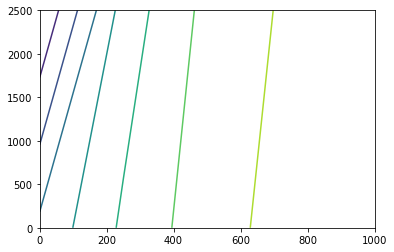

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# get all head data
head = sim.simulation_data.mfdata['example_model', 'HDS', 'HEAD']
# get the head data from the end of the model run
head_end = head[-1]
# plot the head data from the end of the model run
levels = np.arange(160,162,1)
extent = (0.0, 1000.0, 2500.0, 0.0)
plt.contour(head_end[0, :, :],extent=extent)
plt.show()

Results can also be retrieved using the existing binaryfile method.

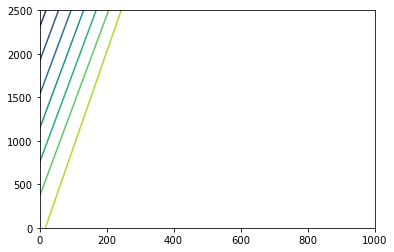

In [29]:
# get head data using old flopy method
hds_path = os.path.join(sim_path, model_name + '.hds')
hds = flopy.utils.HeadFile(hds_path)
# get heads after 1.0 days
head = hds.get_data(totim=1.0)
# plot head data
plt.contour(head[0, :, :],extent=extent)
plt.show()